<a href="https://colab.research.google.com/github/louischarnay/CPE-DataMining-init/blob/main/README.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Téléchargement des images

In [ ]:
pip install SPARQLWrapper

In [ ]:
import sys
import requests
import shutil
import os
import uuid
import json
import math

import matplotlib.pyplot as plot
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
from PIL.ExifTags import TAGS


endpoint_url = "https://query.wikidata.org/sparql"

# Get paintings
query = """SELECT DISTINCT ?painting ?paintingLabel ?creator ?creatorLabel ?country ?countryLabel ?genre ?genreLabel ?timePeriod ?timePeriodLabel ?width ?height (GROUP_CONCAT(DISTINCT ?depictsLabel; separator=", ") as ?depictsLabels) ?image WHERE {
  ?painting wdt:P31 wd:Q3305213;
    wdt:P495  ?country;
    wdt:P170  ?creator;
    wdt:P136  ?genre;
    wdt:P2348 ?timePeriod;
    wdt:P2049 ?width;
    wdt:P2048 ?height;
    wdt:P180  ?depicts;
    wdt:P18   ?image.

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }

  # Retrieve labels for depicts entities
  OPTIONAL {
    ?depicts rdfs:label ?depictsLabel.
    FILTER(LANG(?depictsLabel) = "en")
  }
}
GROUP BY ?painting ?paintingLabel ?creator ?creatorLabel ?country ?countryLabel ?genre ?genreLabel ?timePeriod ?timePeriodLabel ?width ?height ?image
LIMIT 200"""

def create_images_folder():
    if not os.path.exists('images'):
        os.makedirs('images')

def delete_images():
    folder = "images/"
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print("Failed to delete %s. Reason: %s" % (file_path, e))

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

def download_image(row):
    headers = {"User-Agent": "Mozilla/5.0"}
    print(f"Downloading image for row: {row['painting']}")
    request = requests.get(row["image"], allow_redirects=True, headers=headers, stream=True)
    content_length = int(request.headers.get("Content-Length", 0))
    filename = os.path.basename(str(uuid.uuid1()))
    if request.status_code == 200 and content_length < 10000000:
        row["id"] = filename
        # Save image to file
        src = os.path.join("images/", filename + ".png")
        with open(src, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    else:
        print(f"Failed to download image for row. Status code: {request.status_code}")
    return request.status_code


create_images_folder()

array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            None,
            result["paintingLabel"]["value"],
            result["creatorLabel"]["value"],
            result["countryLabel"]["value"],
            result["genreLabel"]["value"],
            result["timePeriodLabel"]["value"],
            result["width"]["value"],
            result["height"]["value"],
            result["depictsLabels"]["value"],
            result["image"]["value"],
        )
    )

dataframe = pd.DataFrame(array, columns=["id", "painting", "creator", "country", "genre", "timePeriod", "width", "height", "depicts", "image"])
dataframe = dataframe.astype(
    dtype={"id": "<U200", "painting": "<U200", "creator": "<U200", "country": "<U200", "genre": "<U200", "timePeriod": "<U200", "width": "<U200", "height": "<U200", "depicts": "<U200", "image": "<U200"}
)

delete_images()

result = dataframe.apply(download_image, axis=1)


Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200
Failed to download image for row. Status code: 200


# Compression des images

Afin d'optimiser l'affichage des images, nous allons réduire drastiquement leur taille et les copier dans un autre dossier.

In [ ]:
from PIL import Image
import shutil
import os

def create_reduced_images_folder():
    if not os.path.exists('reduced-images'):
        os.makedirs('reduced-images')


def delete_reduced_images():
    folder = "reduced-images/"
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print("Failed to delete %s. Reason: %s" % (file_path, e))


def compress_image(image_name):
    filepath = os.path.join(os.getcwd(), "images/" + image_name)
    image = Image.open(filepath)

    max_width = 200
    width, height = image.size
    aspect_ratio = width / height
    newheight = max_width / aspect_ratio

    image = image.resize((max_width, round(newheight)))

    image.save("reduced-images/" + image_name, optimize=True)
    print("Image reduced: " + image_name)

images = []
for file in os.listdir("images"):
    if ".png" in file:
        images.append(file)

create_reduced_images_folder()
delete_reduced_images()

for image_name in images:
    compress_image(image_name)

Image reduced: f3596964-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: d376a3dc-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: ce04ac50-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: f4029750-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: eb9ec2d2-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: d0ca09d0-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: d21cd268-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: cf42424e-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: dd393a9c-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: d17473de-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: da4611ac-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: e866b822-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: d412a606-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: ea50d960-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: ee6eda24-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: dff77712-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: f1e7c850-ea7d-11ee-90ef-0242ac1c000c.png
Image reduced: e4383c9e-ea7d-11ee-90ef-0242ac1c0

# Annotations et récupération des EXIF

In [ ]:
def create_exif_folder():
    if not os.path.exists('exif'):
        os.makedirs('exif')

def create_data_folder():
    if not os.path.exists('data'):
        os.makedirs('data')

def delete_exif():
    folder = "exif/"
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print("Failed to delete %s. Reason: %s" % (file_path, e))

def delete_data():
    folder = "data/"
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print("Failed to delete %s. Reason: %s" % (file_path, e))

def get_exif_data(src):
    imgfile = Image.open(src)
    exif_data = imgfile._getexif()

    exif_metadata = {}

    if exif_data:
        for tag, value in exif_data.items():
            if tag in TAGS:
                exif_metadata[TAGS[tag]] = str(value)

    return exif_metadata

def get_json_data(row):
    depicts_list = [depict.strip() for depict in row["depicts"].split(',')]

    json_data = {
        "id": row["id"],
        "painting": row["painting"],
        "artist": row["creator"],
        "country": row["country"],
        "genre": row["genre"],
        "timePeriod": row["timePeriod"],
        "depicts": depicts_list
    }

    return json_data

def download_data(row):
    if row["id"] != "None":
        print(f"Downloading data for row: {row['painting']}")
        # Get metadata from image to save in a JSON file
        src = os.path.join("images/", row["id"] + ".png")
        exif_data = get_exif_data(src)
        src = "exif/" + row["id"] + ".json"
        with open(src, "w") as json_file:
            json.dump(exif_data, json_file, indent=4, ensure_ascii=False)

        # Save row data to a json file
        src = "data/" + row["id"] + ".json"
        json_data = get_json_data(row)
        with open(src, "w") as json_file:
            json.dump(json_data, json_file, indent=4, ensure_ascii=False)

create_exif_folder()
create_data_folder()

delete_exif()
delete_data()

result = dataframe.apply(download_data, axis=1)

# Cluster de couleurs
Nous allons créé un cluster de couleurs pour chaque image récupérée. Cela va permettre de récupérer les couleurs principales de l'image en format RGB. Ces couleurs vont ensuite être converties en nom pour faciliter la recherche par la suite.

In [ ]:
import numpy
import math
import os
from PIL import Image
from sklearn.cluster import MiniBatchKMeans

cluster_count = 3

def get_cluster_colors(filename):
    image = Image.open("reduced-images/" + filename)
    numarray = numpy.array(image.getdata(), numpy.uint8)

    cluster = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
    cluster.fit(numarray)

    return cluster


# Read images in the images folder
images = os.listdir("reduced-images/")
images_cluster = []
for image in images:
    print(f"Getting clusters for image: {image}")

    clusters = get_cluster_colors(str(image))
    image_name = os.path.splitext(str(image))[0]
    images_cluster.append((image_name, clusters))

Getting clusters for image: f3596964-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: d376a3dc-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: ce04ac50-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: f4029750-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: eb9ec2d2-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: d0ca09d0-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: d21cd268-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: cf42424e-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: dd393a9c-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: d17473de-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: da4611ac-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: e866b822-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: d412a606-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: ea50d960-ea7d-11ee-90ef-0242ac1c000c.png
Getting clusters for image: ee6eda

Ces couleurs vont ensuite être enregistrées dans un CSV portant le nom de l'image.

In [ ]:
from scipy.spatial import KDTree
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
)

def convert_rgb_to_name(rgb_tuple):
    names = []
    rgb_values = []
    for color_hex, color_name in CSS3_HEX_TO_NAMES.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))

    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return names[index]

def convert_cluster_to_color_names(cluster):
    cluster_centers_rgb = cluster.cluster_centers_.astype(numpy.uint8)
    return [convert_rgb_to_name(tuple(color)) for color in cluster_centers_rgb]

for image_cluster in images_cluster:
    colors_name = convert_cluster_to_color_names(image_cluster[1])
    with open(f"data/{image_cluster[0]}.json", "r") as file:
      try:
        data = json.load(file)

        # Add 'colors' field to the JSON data
        data['colors'] = colors_name

        if 'colors' in data:
          data['colors'] = data['colors']

        print(data)

        # Write updated data to the JSON file
        with open(f"data/{image_cluster[0]}.json", "w") as outfile:
            json.dump(data, outfile, indent=4)
      except json.JSONDecodeError:
          print("Error: The file does not contain valid JSON data or is empty.")


{'id': 'f3596964-ea7d-11ee-90ef-0242ac1c000c', 'painting': 'Self-Portrait', 'artist': 'Ren Xiong', 'country': 'Qing Dynasty', 'genre': 'ink and color painting', 'timePeriod': 'Qing Dynasty', 'depicts': ['Ren Xiong'], 'colors': ['darkgray', 'gainsboro', 'darkslategray']}
{'id': 'd376a3dc-ea7d-11ee-90ef-0242ac1c000c', 'painting': 'Pavilion by the Lake', 'artist': 'http://www.wikidata.org/.well-known/genid/1ee37253b663e73c8a1b013fe3da1b90', 'country': 'Korea', 'genre': 'landscape art', 'timePeriod': 'Joseon', 'depicts': ['house', 'mountain', 'tree', 'landscape art', 'pavilion'], 'colors': ['lightgray', 'darkslategray', 'gray']}
{'id': 'ce04ac50-ea7d-11ee-90ef-0242ac1c000c', 'painting': 'Crucifixion', 'artist': 'Andrea Mantegna', 'country': 'Italy', 'genre': 'religious art', 'timePeriod': 'Early Renaissance', 'depicts': ['man', 'Jesus', 'Virgin Mary'], 'colors': ['darkolivegreen', 'gray', 'silver']}
{'id': 'f4029750-ea7d-11ee-90ef-0242ac1c000c', 'painting': 'Charles IV of Spain and His Fam

En bonus, voici les graphes avec le cluster de couleurs de chaque image.

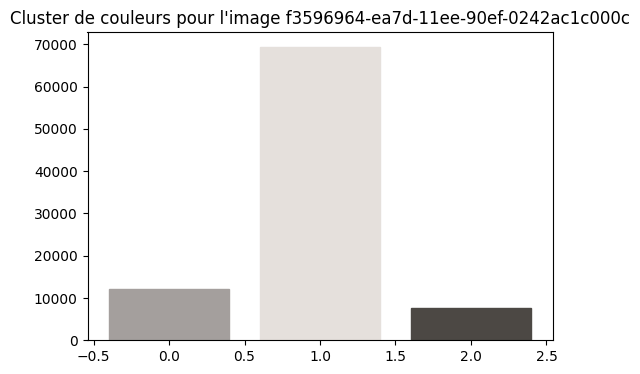

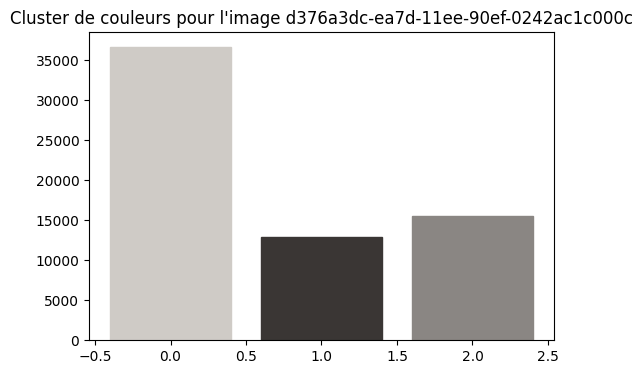

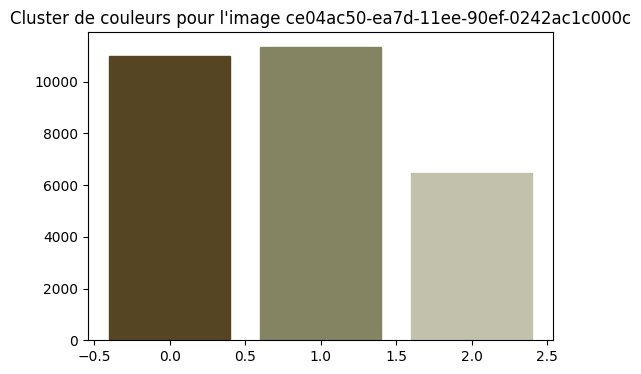

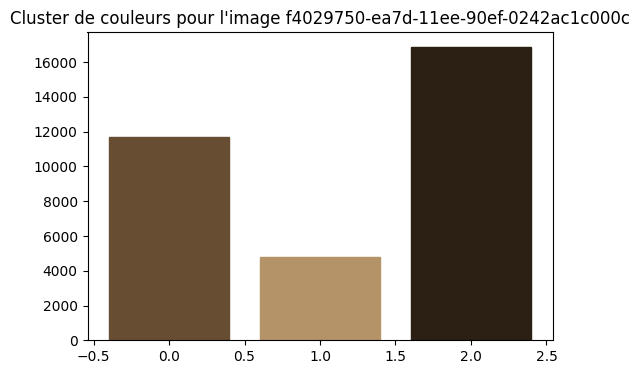

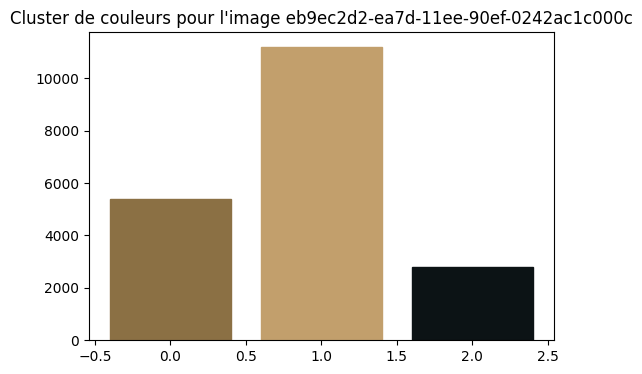

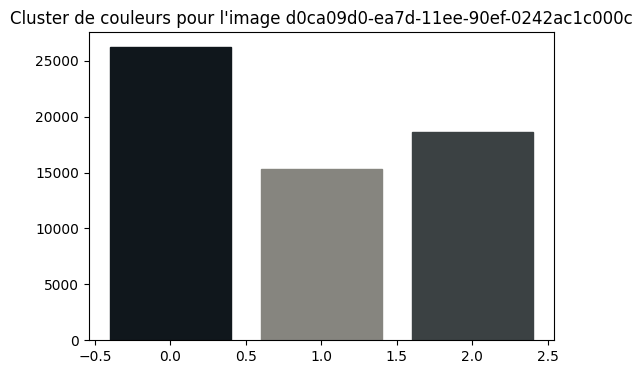

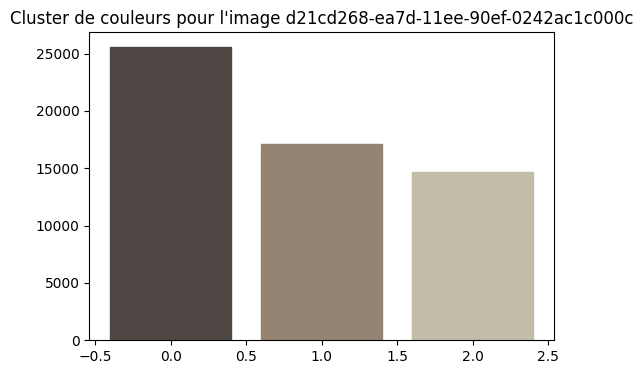

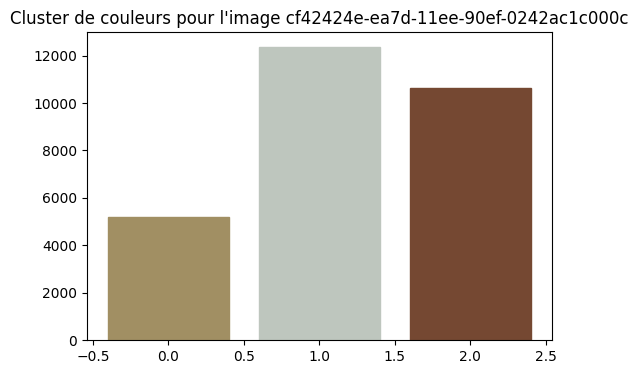

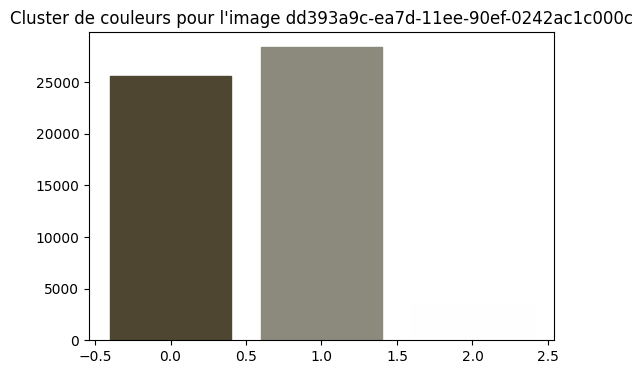

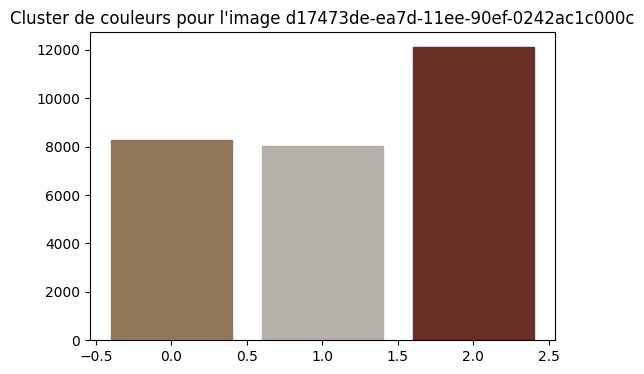

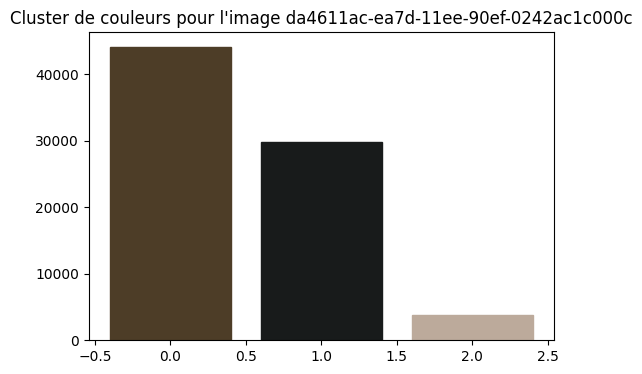

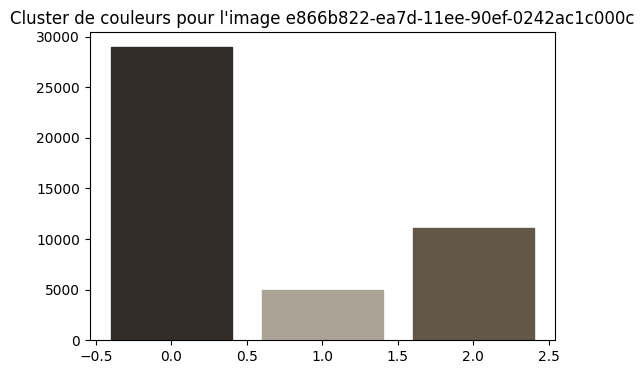

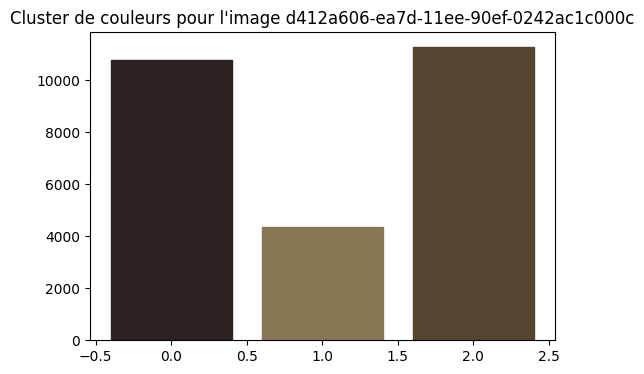

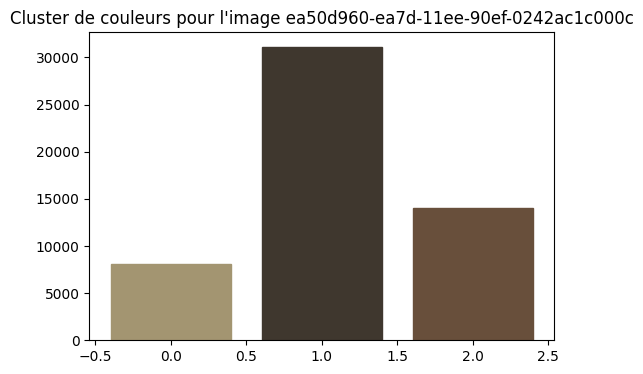

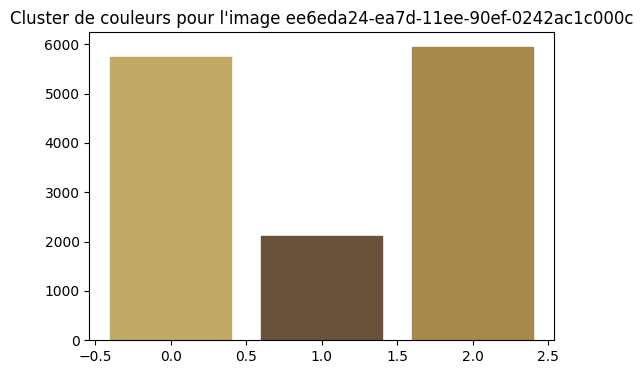

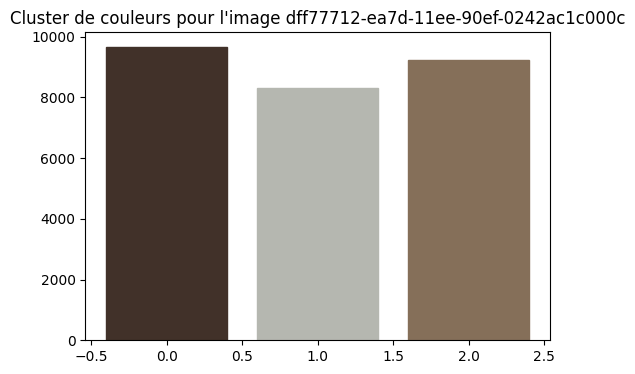

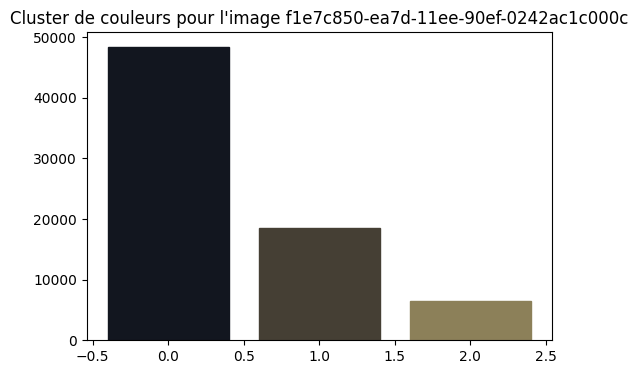

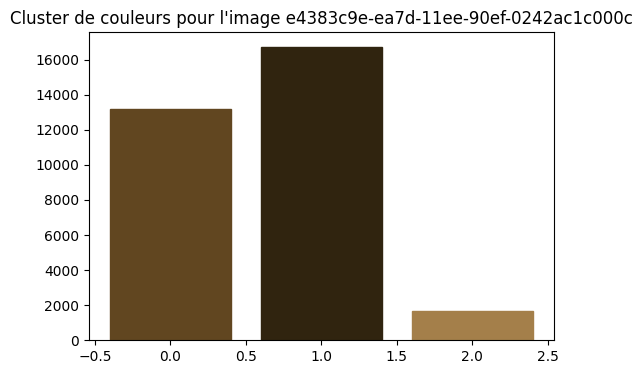

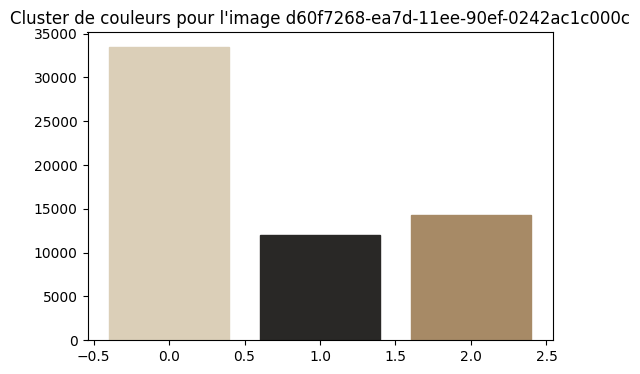

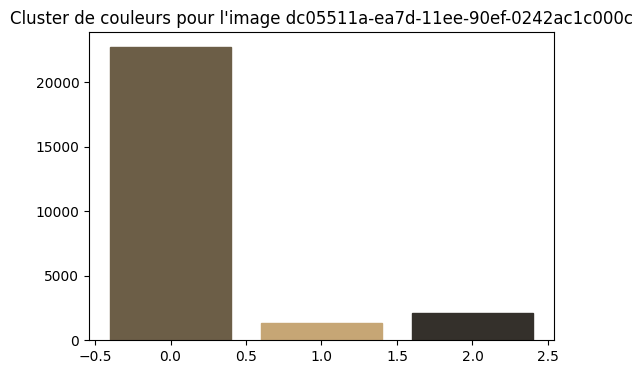

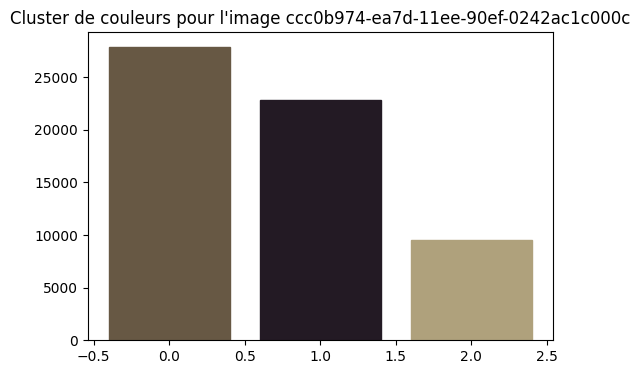

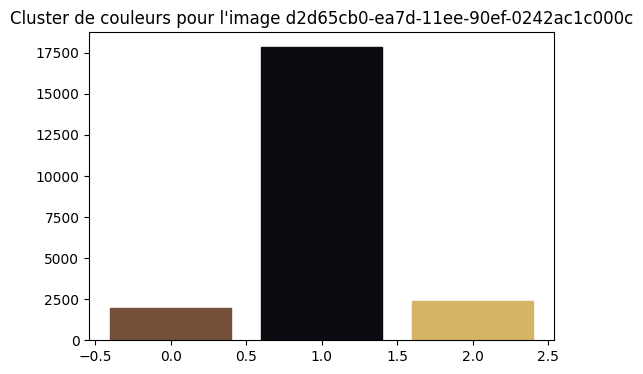

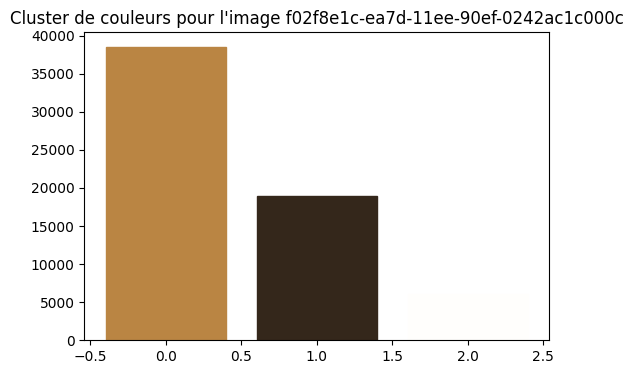

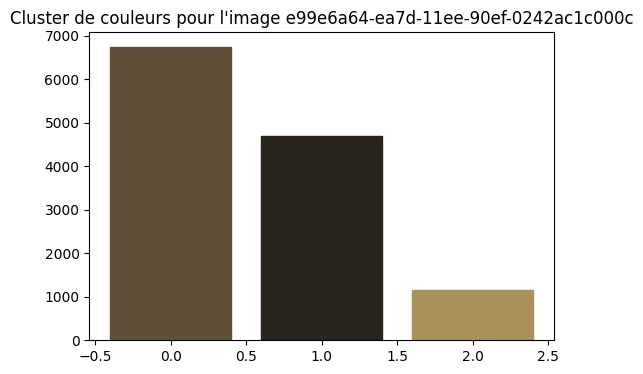

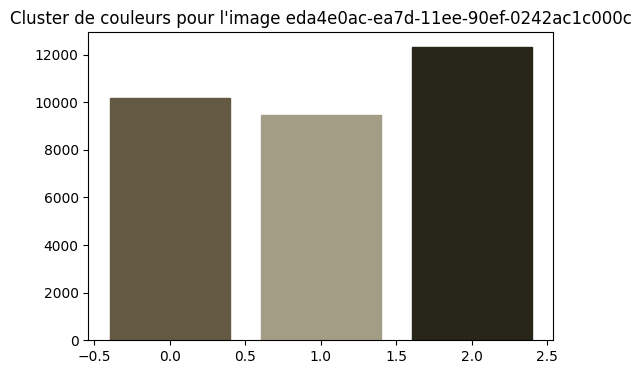

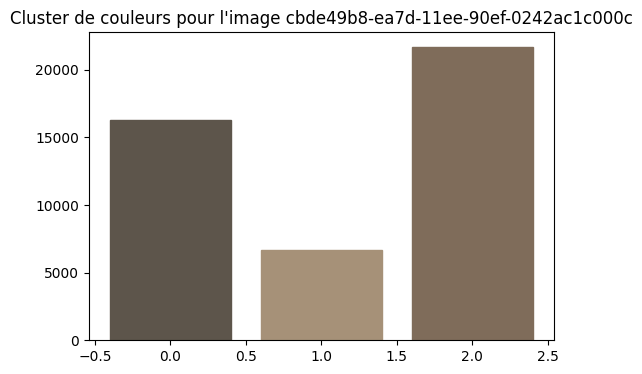

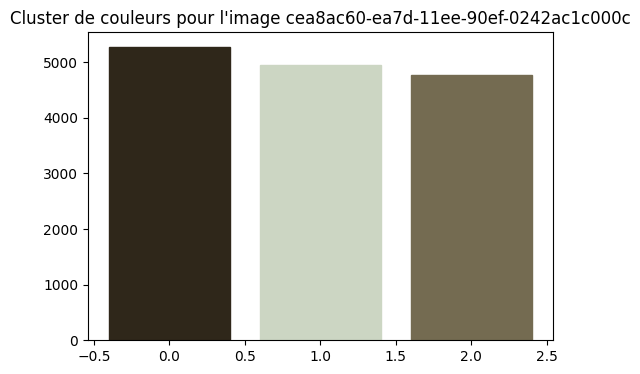

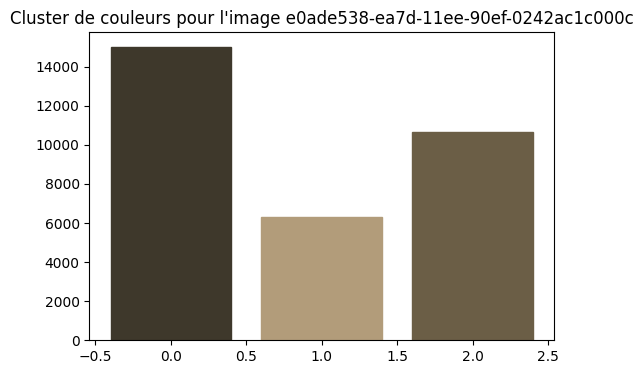

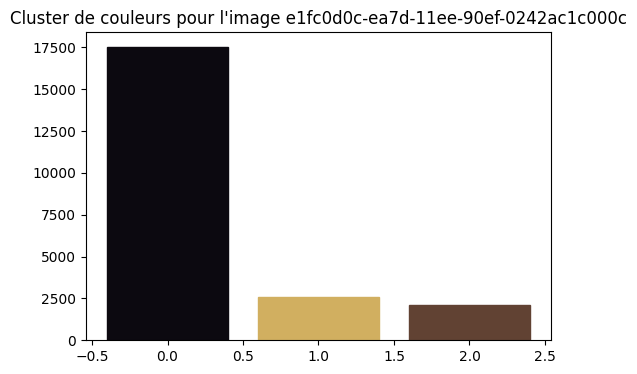

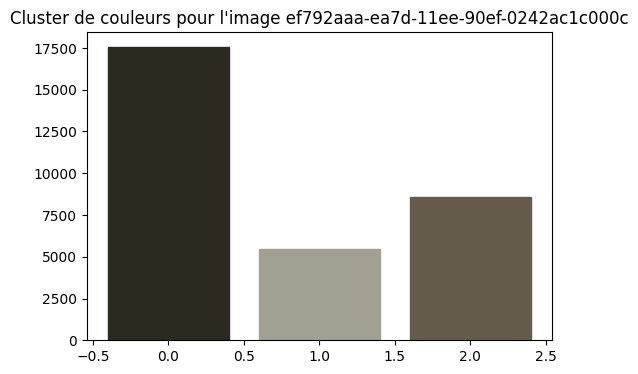

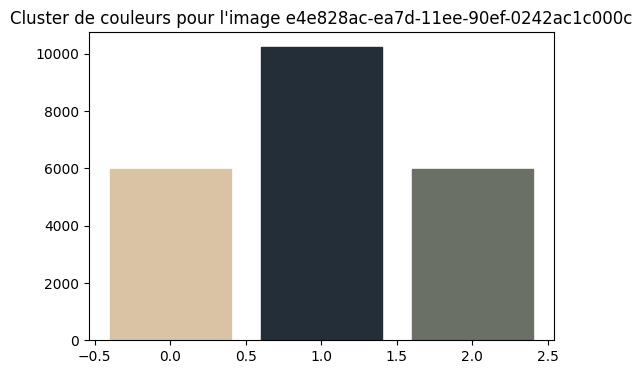

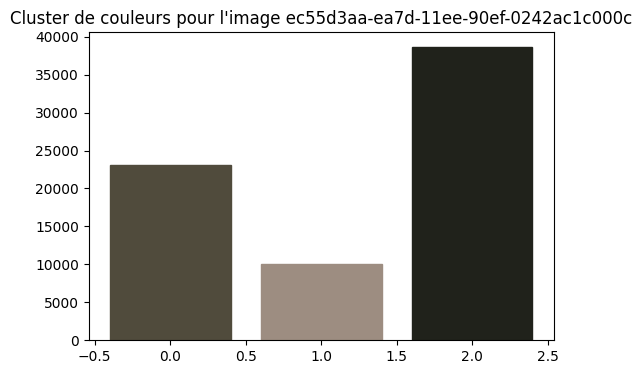

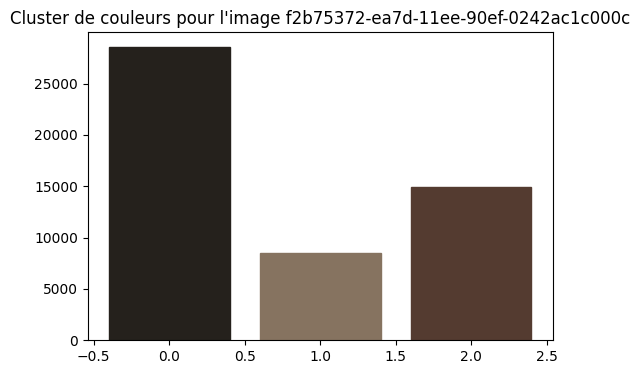

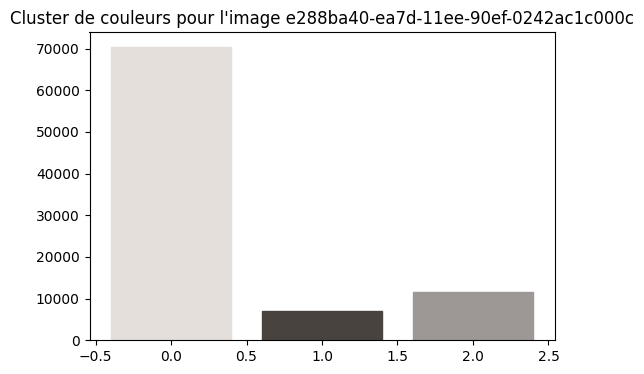

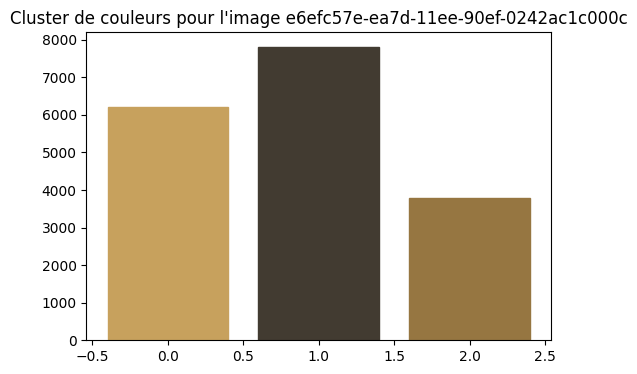

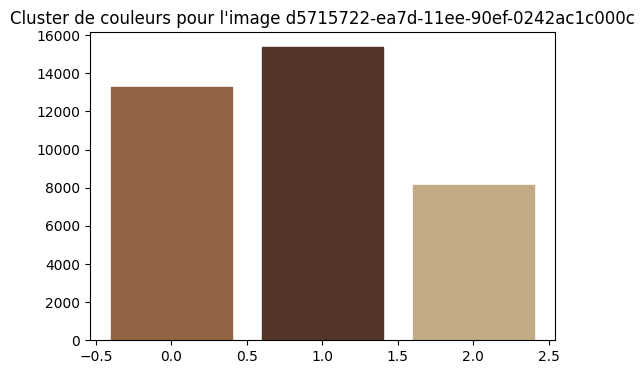

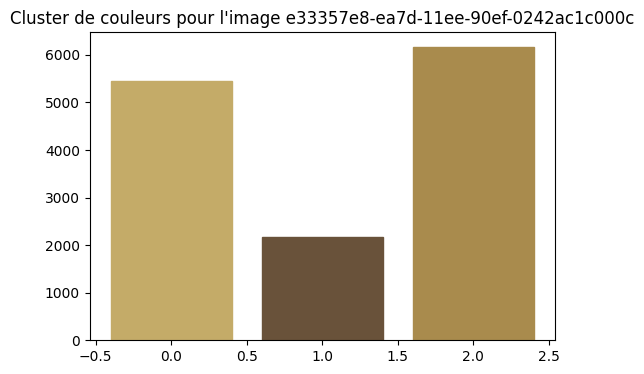

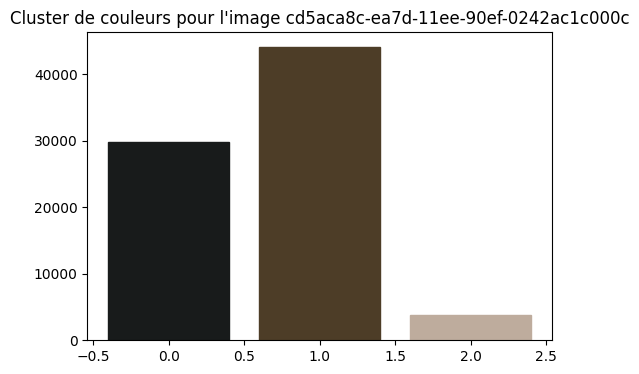

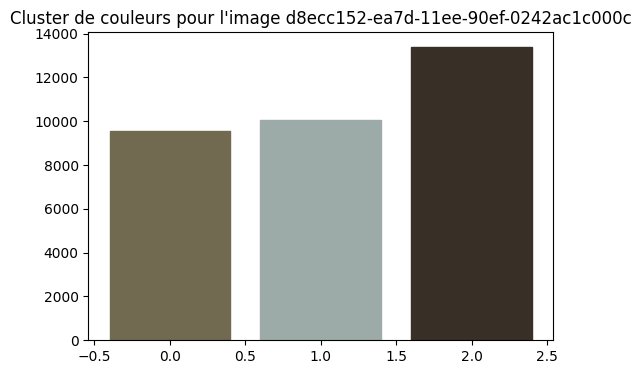

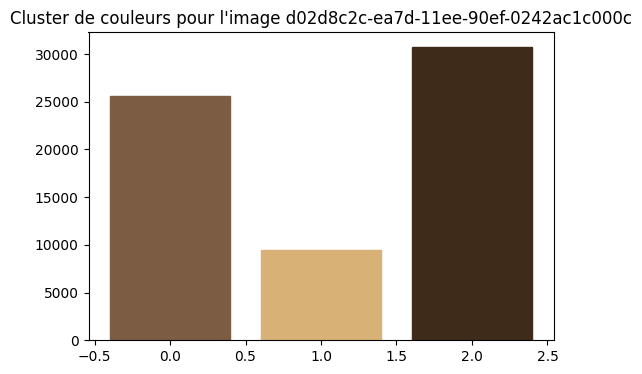

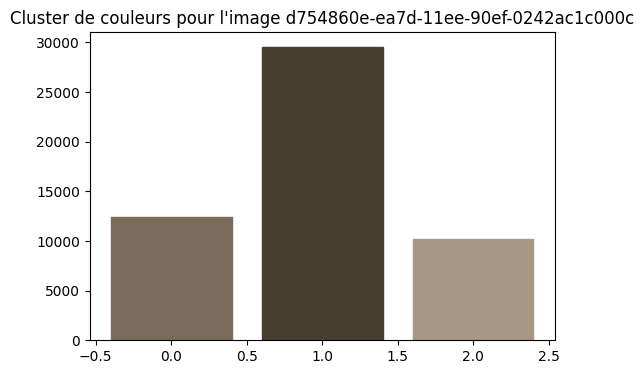

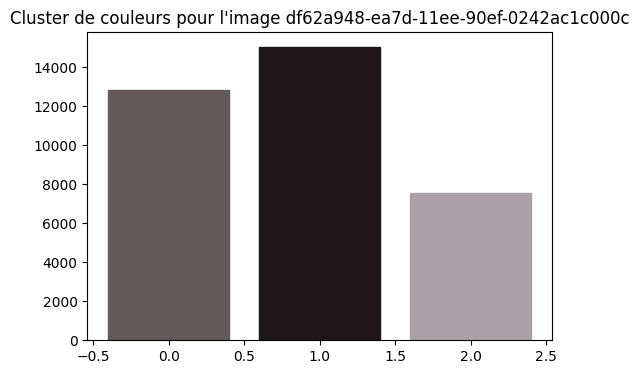

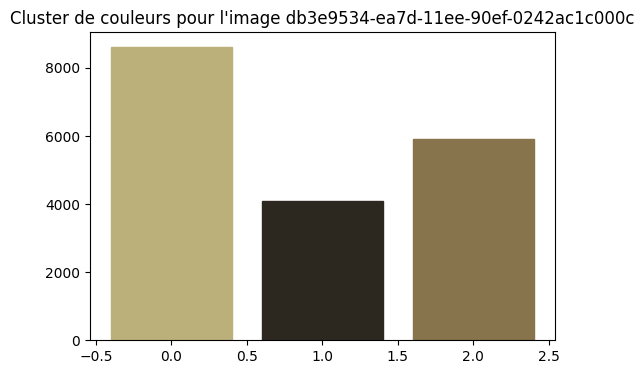

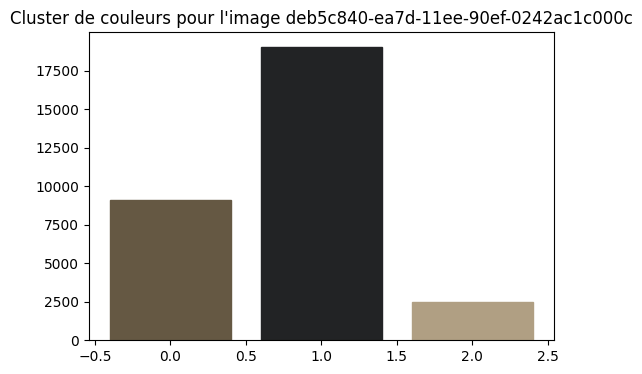

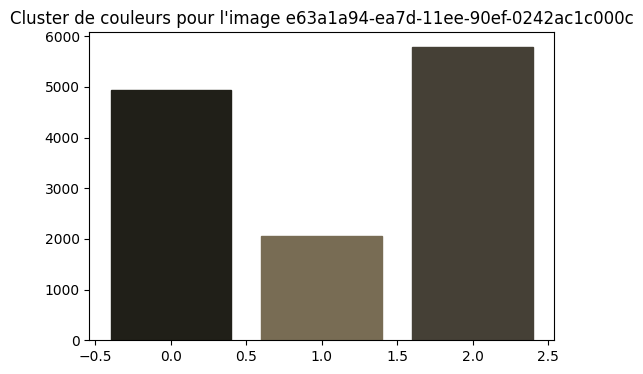

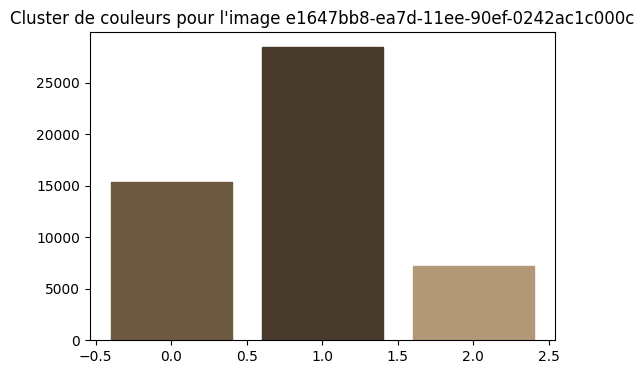

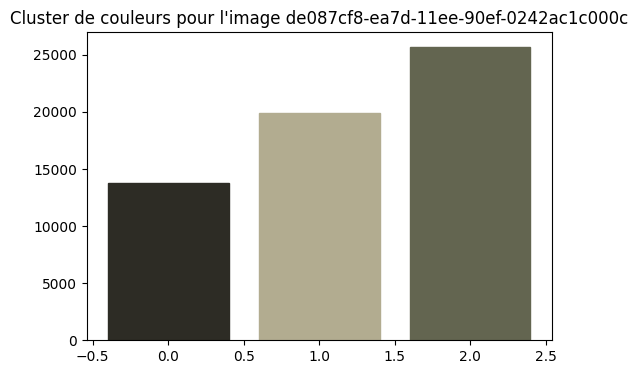

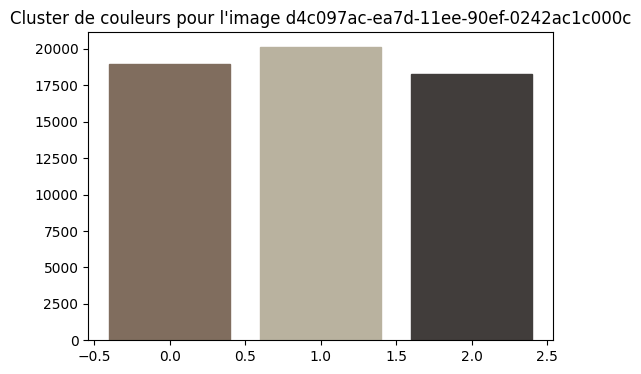

In [ ]:
import numpy
import math
import os
import matplotlib.pyplot as plot

for image_name, clusters in images_cluster:
    fig, axes = plot.subplots(nrows=1, ncols=1, figsize=(6, 4))

    # Plot the color cluster
    npbins = numpy.arange(0, cluster_count + 1)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)
    barlist = axes.bar(labels, histogram[0])

    for i in range(cluster_count):
        barlist[i].set_color(
            "#%02x%02x%02x"
            % (
                math.ceil(clusters.cluster_centers_[i][0]),
                math.ceil(clusters.cluster_centers_[i][1]),
                math.ceil(clusters.cluster_centers_[i][2]),
            )
        )

    plot.title(f"Cluster de couleurs pour l'image {image_name}")
    plot.show()

# Regroupement des images par tags

In [ ]:
import json
import os

def buildMatrix(tags, incidence_matrix, image_names):
    all_tags = []
    # Dictionary to map each image to its tags
    image_tags_mapping = {}

    # Iterate over all JSON files in the directory
    for filename in os.listdir(json_directory):
        if filename.endswith(".json"):
            json_file_path = os.path.join(json_directory, filename)
            # Read the JSON file
            print(f"Reading JSON file: {json_file_path}")
            with open(json_file_path, "r", encoding="utf-8") as file:
                try:
                    data = json.load(file)
                except json.JSONDecodeError:
                    print(f"Error reading JSON file: {json_file_path}")
                    continue
                if isinstance(data, dict):  # Ensure data is a dictionary
                    image_name = data.get("painting")
                    if image_name:
                        # Append a unique identifier to image_name
                        image_name_unique = f"{image_name}_{filename[:-5]}"  # Assuming the filename is unique
                        print(f"Image name: {image_name_unique}")
                        image_tags = []
                        for tag in tags:
                            tag_value = data.get(tag, "")
                            if isinstance(tag_value, list):
                                image_tags.extend(tag_value)
                            else:
                                image_tags.append(tag_value)
                        print(f"Tags: {image_tags}")
                        image_tags_mapping[image_name_unique] = image_tags
                        all_tags.extend(image_tags)
                else:
                    print(f"Unexpected format in JSON file: {json_file_path}")

    # Remove duplicate tags
    unique_tags = list(set(all_tags))
    print(f"Unique tags: {unique_tags}")

    # Ensure all image names have a corresponding row in the incidence matrix
    for image_name in image_names:
        if image_name not in image_tags_mapping:
            image_tags_mapping[image_name] = []  # Add image with empty tags

    # Construct the incidence matrix
    for image_name, image_tags in image_tags_mapping.items():
        row = [1 if tag in image_tags else 0 for tag in unique_tags]
        incidence_matrix.append(row)
        image_names.append(image_name)

    # Display the incidence matrix (for the first few images for illustration)
    for i, row in enumerate(incidence_matrix[:100]):
        print(f"Image {image_names[i]}: {row}")

# Path to the directory containing the JSON files
json_directory = "data/"

# Define the tags you want to use for the incidence matrix
tags = ["artist", "country", "genre", "timePeriod"]
colors = ["colors"]
depicts = ["depicts"]

incidence_matrix = []
incidence_matrix_colors = []
incidence_matrix_depicts = []

image_names = []
buildMatrix(tags, incidence_matrix, image_names)
buildMatrix(colors, incidence_matrix_colors, image_names)
buildMatrix(depicts, incidence_matrix_depicts, image_names)

Reading JSON file: data/f4029750-ea7d-11ee-90ef-0242ac1c000c.json
Image name: Charles IV of Spain and His Family_f4029750-ea7d-11ee-90ef-0242ac1c000c
Tags: ['Francisco Goya', 'Spain', 'group portrait', 'Romanticism']
Reading JSON file: data/ce04ac50-ea7d-11ee-90ef-0242ac1c000c.json
Image name: Crucifixion_ce04ac50-ea7d-11ee-90ef-0242ac1c000c
Tags: ['Andrea Mantegna', 'Italy', 'religious art', 'Early Renaissance']
Reading JSON file: data/deb5c840-ea7d-11ee-90ef-0242ac1c000c.json
Image name: The Third of May 1808_deb5c840-ea7d-11ee-90ef-0242ac1c000c
Tags: ['Francisco Goya', 'Spain', 'history painting', 'Romanticism']
Reading JSON file: data/cd5aca8c-ea7d-11ee-90ef-0242ac1c000c.json
Image name: Portrait of Madame X_cd5aca8c-ea7d-11ee-90ef-0242ac1c000c
Tags: ['John Singer Sargent', 'United States of America', 'portrait', 'Edwardian era']
Reading JSON file: data/d4c097ac-ea7d-11ee-90ef-0242ac1c000c.json
Image name: Brera Madonna_d4c097ac-ea7d-11ee-90ef-0242ac1c000c
Tags: ['Piero della Franc

# Représentation des images sous forme de clusters par tags

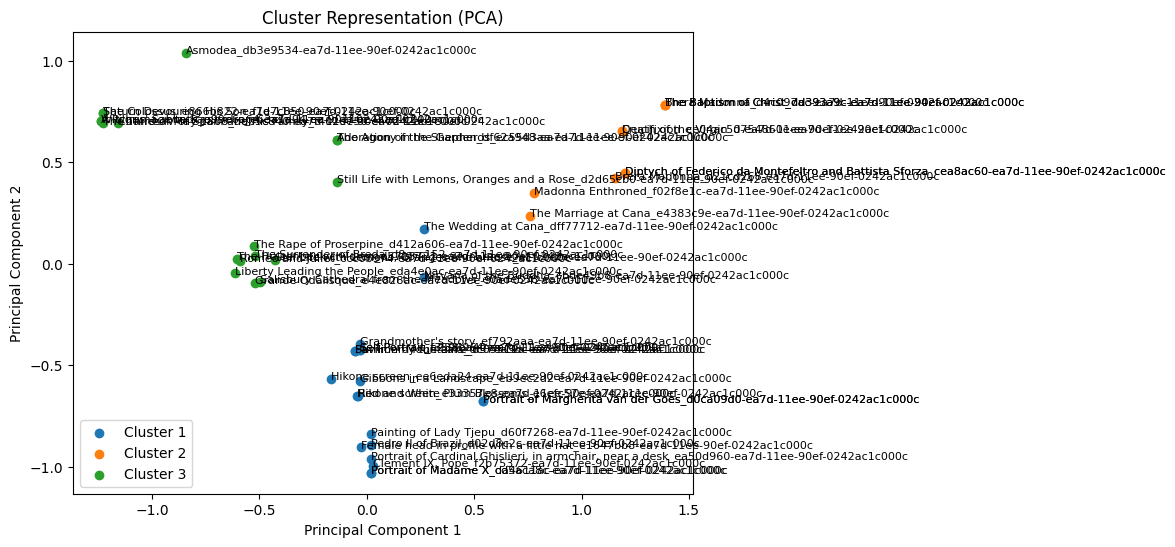

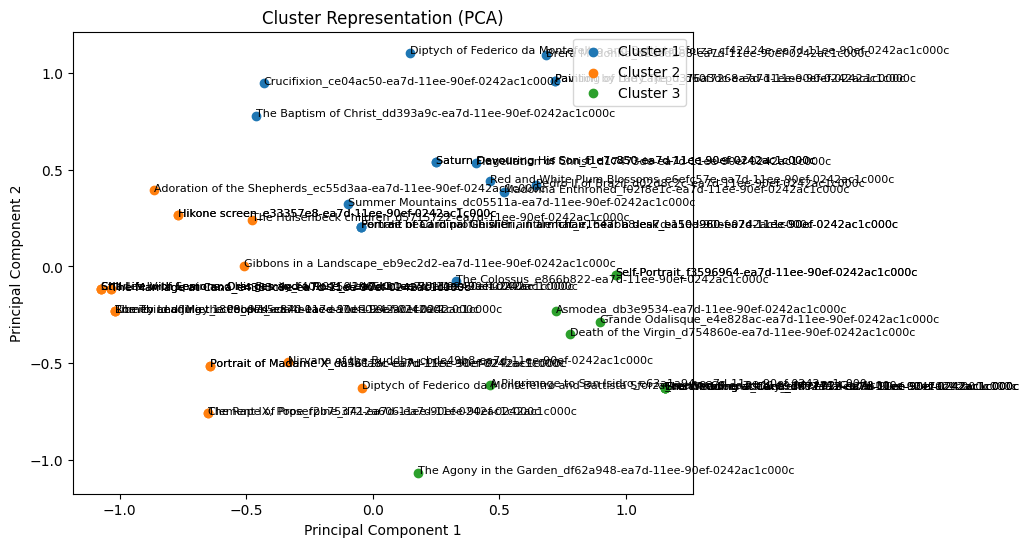

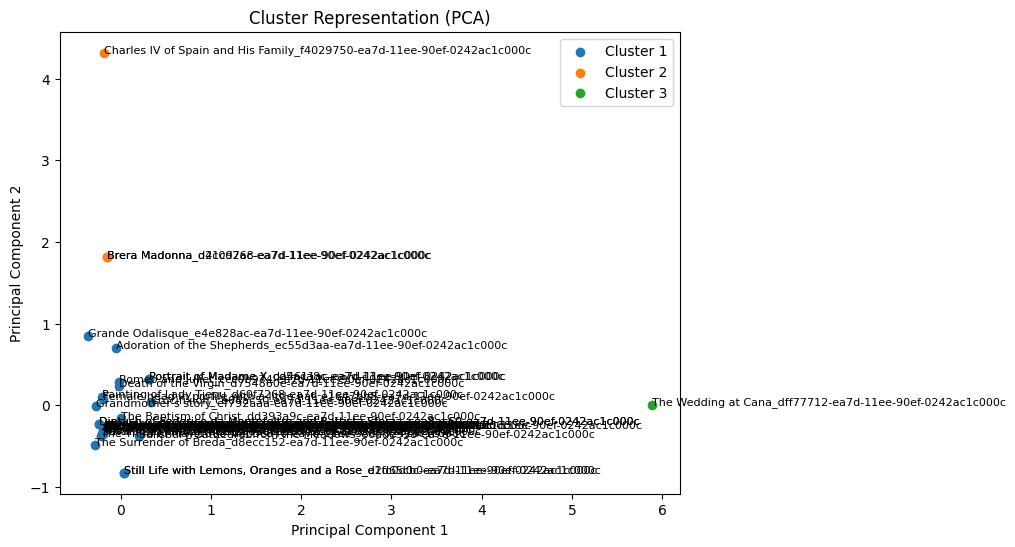

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def displayCluster(incidence_matrix, image_names):
    # Convert the incidence matrix to a numpy array
    incidence_array = np.array(incidence_matrix)

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
    reduced_features = pca.fit_transform(incidence_array)

    # Perform K-means clustering
    k = 3  # Number of clusters (you can adjust this)
    cluster = KMeans(n_clusters=k, n_init=4)
    clusters = cluster.fit_predict(reduced_features)

    # Visualize the clusters
    plt.figure(figsize=(8, 6))
    for cluster_label in range(k):
        cluster_points = reduced_features[clusters == cluster_label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label+1}')
        # Annotate points with image names
        for i, point in enumerate(cluster_points):
            plt.text(point[0], point[1], image_names[np.where((reduced_features == point).all(axis=1))[0][0]], fontsize=8)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Cluster Representation (PCA)')
    plt.legend()
    plt.show()
    print("\n")

displayCluster(incidence_matrix, image_names)
displayCluster(incidence_matrix_colors, image_names)
displayCluster(incidence_matrix_depicts, image_names)

# Choix des images favorites

L'utilisateur va choisir ses images préférées.

In [ ]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.6 MB/s eta 0:00:00



Nous affichons les images sélectionnables en tant que favoris. Après avoir sélectionné les images et cliqué sur le bouton de validation, les liens des images sont enregistrés dans un fichier CSV.

In [ ]:
import ipywidgets as widgets
from ipywidgets import GridspecLayout, Image, interact
import csv

def create_favorite_images_folder():
    if not os.path.exists('favorite-images'):
        os.makedirs('favorite-images')


def display_image_selection_for(user_name):
    paths = []
    checkboxes = [widgets.Checkbox(value=False, description='Favorite') for _ in range(len(images))]

    # Create the GridspecLayout widget
    layout = GridspecLayout(n_columns=2, n_rows=len(images), width='500px')
    for i, (img, checkbox) in enumerate(zip(images, checkboxes)):
      file = open("reduced-images/" + img, "rb")
      image = file.read()
      image_widget = widgets.Image(
        value=image,
        format='png',
        height=200,
      )
      layout[i,0] = image_widget
      layout[i, 1] = checkbox

    # Button to get selected images
    button = widgets.Button(description="Select")

    # Output widget to display selected images
    output = widgets.Output()


    def get_selected_images(btn):
        global paths
        paths = []
        selected_paths = [images[i] for i, checkbox in enumerate(checkboxes) if checkbox.value]
        with output:
            output.clear_output()
            for path in selected_paths:
                paths.append(path)
        write_to_csv(paths)


    def write_to_csv(paths):
        file_path = "favorite-images/" + user_name + ".csv"

        with open(file_path, 'w', newline="") as file:
            writer = csv.writer(file)
            for path in paths:
                writer.writerow([path])
        print("Images saved in CSV")


    # Link button click event to function
    button.on_click(get_selected_images)

    # Display the layout and button
    display(layout, button, output)


create_favorite_images_folder()

## Mes images favorites

In [ ]:
display_image_selection_for("me")

GridspecLayout(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xc8\x00\x00\x01\x1f\x08…

Button(description='Select', style=ButtonStyle())

Output()

Images saved in CSV


## Images favorites des utilisateurs existants

In [ ]:
display_image_selection_for("user1")

GridspecLayout(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xc8\x00\x00\x00\xa0\x08…

Button(description='Select', style=ButtonStyle())

Output()

In [ ]:
display_image_selection_for("user2")

GridspecLayout(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xc8\x00\x00\x00\xa0\x08…

Button(description='Select', style=ButtonStyle())

Output()

In [ ]:
display_image_selection_for("user3")

GridspecLayout(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xc8\x00\x00\x00\xa0\x08…

Button(description='Select', style=ButtonStyle())

Output()

In [ ]:
display_image_selection_for("user4")

GridspecLayout(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xc8\x00\x00\x00\xa0\x08…

Button(description='Select', style=ButtonStyle())

Output()

# Processus de recommandation

Favorites Pictures for User me:


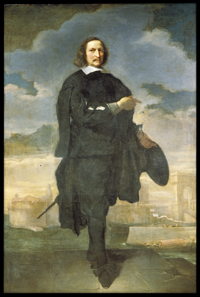




Recommended Pictures for User me:


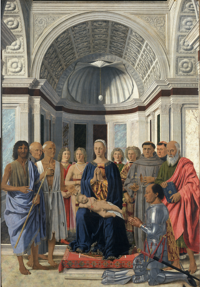

Distance: 2.0


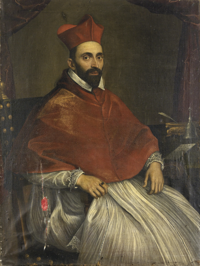

Distance: 2.0


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import os
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, Image

# Function to get image names from the 'images' folder
def get_image_names(folder='reduced-images/'):
    image_names = {}
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_names[filename] = len(image_names)  # Assigning a unique index to each image
    return image_names

# Implement nearest neighbor algorithm
def find_nearest_neighbors(favorite_names, incidence_matrix, k=3):
    nn_model = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(incidence_matrix)
    favorite_indices = [image_names[name] for name in favorite_names]
    print("Favorite Indices:", favorite_indices)  # Print favorite indices
    distances, indices = nn_model.kneighbors([incidence_matrix[fav_idx] for fav_idx in favorite_indices])
    return distances, indices

# Recommend potential liked pictures for a single user based on nearest neighbors
def recommend_pictures(user_favorite_names, incidence_matrix, image_names, k=3):
    favorite_indices = [image_names.get(name) for name in user_favorite_names if name in image_names]
    if not favorite_indices:
        print("No valid favorite images found for this user.")
        return []

    nn_model = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(incidence_matrix)
    distances, indices = nn_model.kneighbors([incidence_matrix[x] for x in favorite_indices])

    recommended_pictures = []
    for i, idx in enumerate(favorite_indices):
        similar_indices = indices[i]
        similar_distances = distances[i]
        for j in range(len(similar_indices)):
            if similar_indices[j] not in favorite_indices:  # Exclude favorites from recommendations
                recommended_pictures.append((similar_indices[j], similar_distances[j]))
    return recommended_pictures

# Example usage:
k = 3  # Number of nearest neighbors to consider
image_names = get_image_names()

# Read favorite images from CSV files for each user and display recommendations
favorite_images_path = 'favorite-images'
for filename in os.listdir(favorite_images_path):
    if filename.endswith('.csv'):
        user_id = filename.split('.')[0]  # Assuming file name is user ID
        user_favorite_images = pd.read_csv(os.path.join(favorite_images_path, filename), header=None)[0].tolist()
        print(f"Favorites Pictures for User {user_id}:")
        for name in user_favorite_images:
            display(Image(filename=f'reduced-images/{name}'))
            print("\n")

        # Recommend potential liked pictures for this user
        recommended_pictures = recommend_pictures(user_favorite_images, incidence_matrix_depicts, image_names, k)
        print(f"\nRecommended Pictures for User {user_id}:")
        for idx, distance in recommended_pictures:
            image_name = list(image_names.keys())[idx]
            display(Image(filename=f'reduced-images/{image_name}'))
            print(f"Distance: {distance}")